# Querying PDF With Astra and LangChain
A question-answering demo using Astra DB and LangChain, powered by Vector Search

- Cassandra DB can be created using a platform called datastax. Create the DB in cloud.
- No SQL database
- Stores massive amount of data
- Scalability and high availability without compromising performance
- Cloud infrastructure
- Speciality is, we can do vector search
- Control flow: Read the document -> convert to text chunck -> Text embedding -> Vector Database (Cassandra DB) -> Then perform similarity search over this with query and generate response
- Vector search - allowing similarity comparision of embedding
- Support various LLMS

## Pre-requisites

You need a Serverless Cassandra with Vector Search database on Astra DB to run this demo. As outlined in more detail here, you should get a DB Token with role Database Administrator and copy your Database ID: these connection parameters are needed momentarily.

What you will do:
- Setup: import dependencies, provide secrets, create the LangChain vector store;
- Run a Question-Answering loop retrieving the relevant headlines and having an LLM construct the answer.

Astra DB creation: https://astra.datastax.com/

Sign it with github or google account

For more details: https://docs.datastax.com/en/astra/astra-db-vector/get-started/quickstart.html#_prepare_for_using_your_vector_database

Create a database

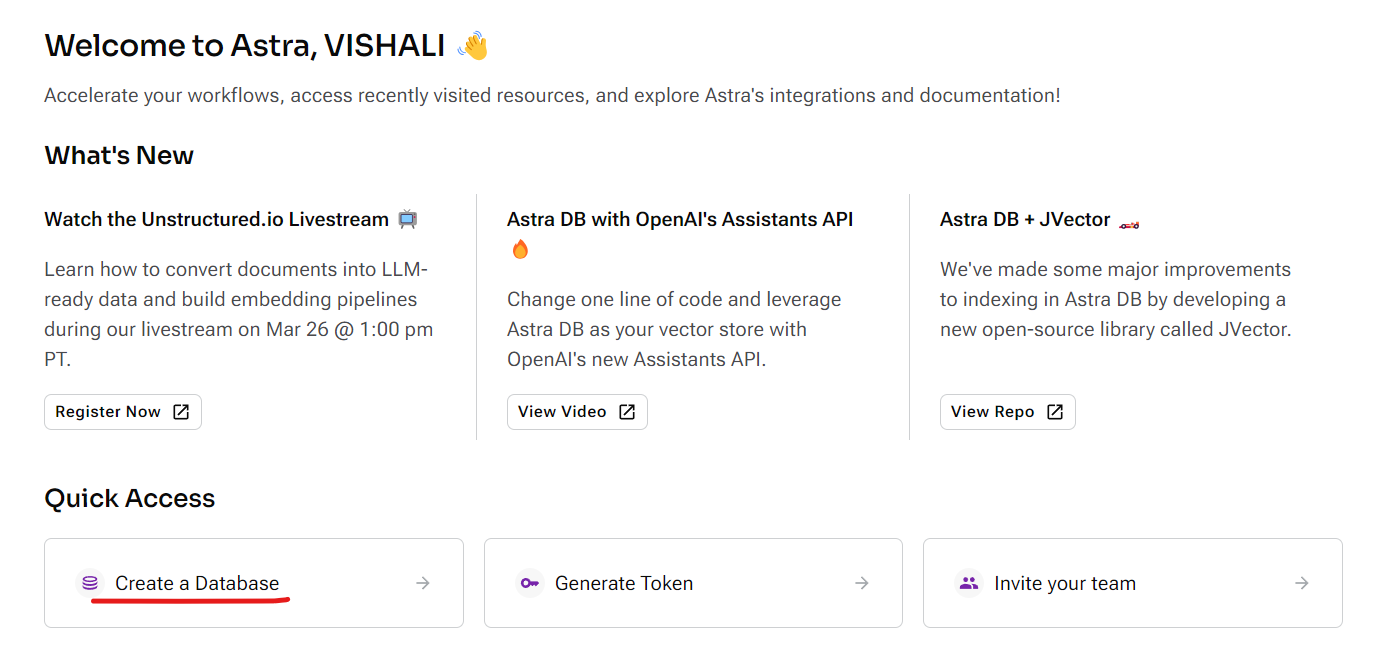

Mention database name, provider and region

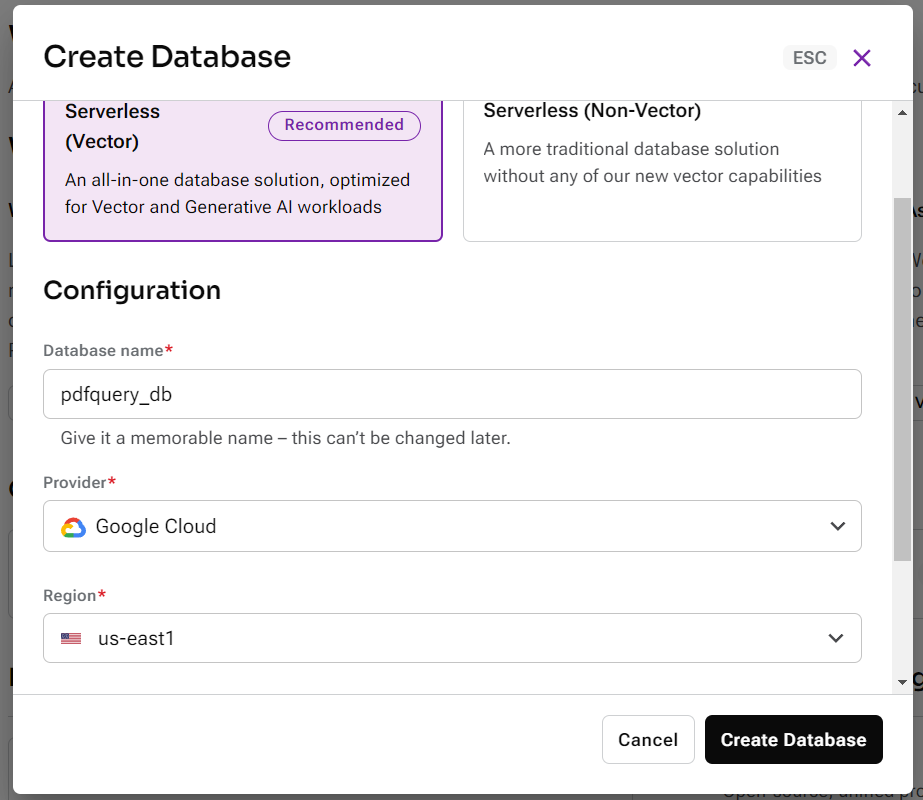

Finally created!!

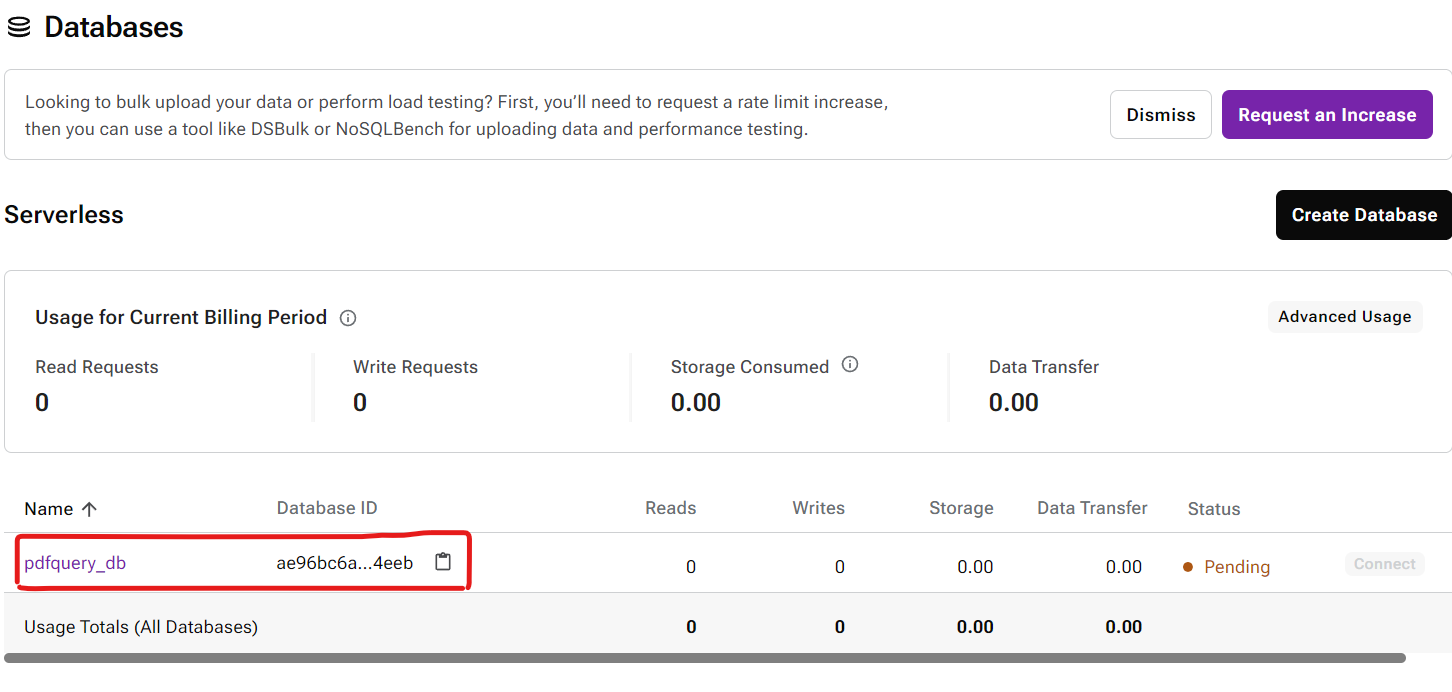

Click on connection details:

You need database ID and token ID

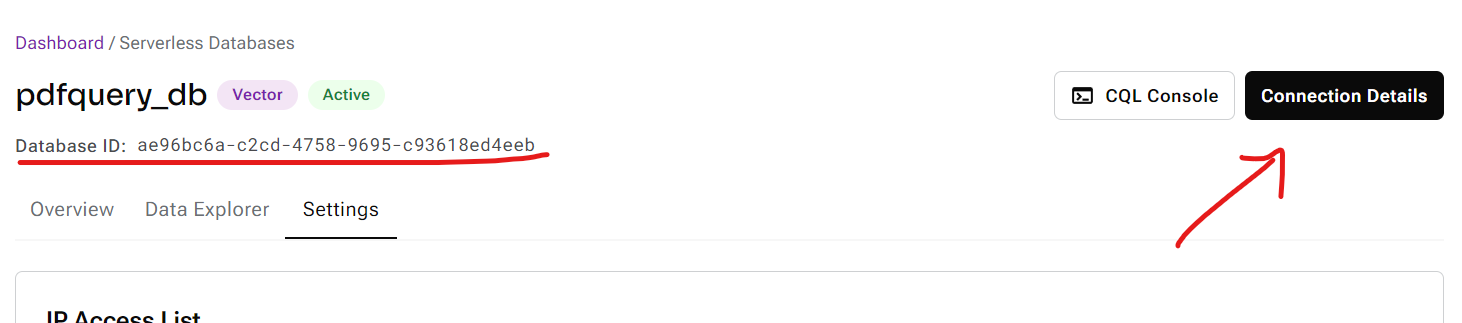

To generate token

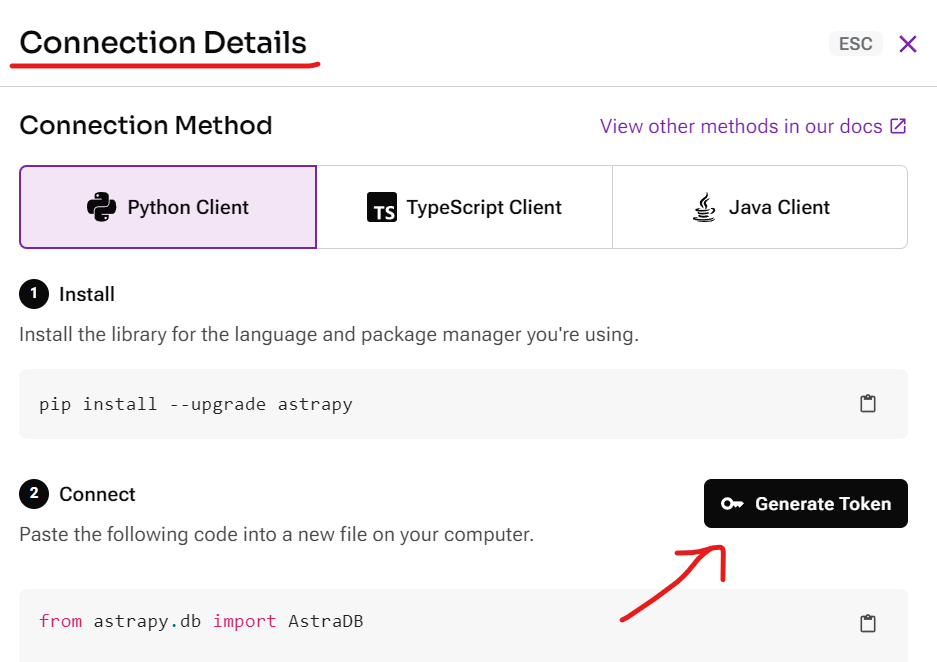

Save token ID and database Id in environment variables

Import all necessary libraries

In [24]:
# LangChain components to use
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
from PyPDF2 import PdfReader
import os
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain_community.llms import HuggingFaceHub
from langchain.text_splitter import CharacterTextSplitter
from typing_extensions import Concatenate

# Support for dataset retrieval with Hugging Face
from datasets import load_dataset

# With CassIO, the engine powering the Astra DB integration in LangChain,
# you will also initialize the DB connection:
import cassio

Load all the environmental variables

In [16]:
load_dotenv()

True

Mention the path of the document

In [17]:
# provide the path of  pdf file/files.
pdfreader = PdfReader('documents/budget_speech.pdf')

Read the text from PDF reader

In [18]:
# read text from pdf
raw_text = ''
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

In [19]:
raw_text

"GOVERNMENT OF INDIA\nBUDGET 2023-2024\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2023CONTENTS \nPART-A \n Page No.  \n\uf0b7 Introduction 1 \n\uf0b7 Achievements since 2014: Leaving no one behind 2 \n\uf0b7 Vision for Amrit Kaal  – an empowered and inclusive economy 3 \n\uf0b7 Priorities of this Budget 5 \ni. Inclusive Development  \nii. Reaching the Last Mile \niii. Infrastructure and Investment \niv. Unleashing the Potential \nv. Green Growth \nvi. Youth Power  \nvii. Financial Sector  \n \n \n \n \n \n \n \n \n\uf0b7 Fiscal Management 24 \nPART B  \n  \nIndirect Taxes  27 \n\uf0b7 Green Mobility  \n\uf0b7 Electronics   \n\uf0b7 Electrical   \n\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 Lab Grown Diamonds  \n\uf0b7 Precious Metals  \n\uf0b7 Metals  \n\uf0b7 Compounded Rubber  \n\uf0b7 Cigarettes  \n  \nDirect Taxes  30 \n\uf0b7 MSMEs and Professionals   \n\uf0b7 Cooperation  \n\uf0b7 Start-Ups  \n\uf0b7 Appeals  \n\uf0b7 Better ta

In [23]:
# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)

In [25]:
texts[:50]

['GOVERNMENT OF INDIA\nBUDGET 2023-2024\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2023CONTENTS \nPART-A \n Page No.  \n\uf0b7 Introduction 1 \n\uf0b7 Achievements since 2014: Leaving no one behind 2 \n\uf0b7 Vision for Amrit Kaal  – an empowered and inclusive economy 3 \n\uf0b7 Priorities of this Budget 5 \ni. Inclusive Development  \nii. Reaching the Last Mile \niii. Infrastructure and Investment \niv. Unleashing the Potential \nv. Green Growth \nvi. Youth Power  \nvii. Financial Sector  \n \n \n \n \n \n \n \n \n\uf0b7 Fiscal Management 24 \nPART B  \n  \nIndirect Taxes  27 \n\uf0b7 Green Mobility  \n\uf0b7 Electronics   \n\uf0b7 Electrical   \n\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 Lab Grown Diamonds  \n\uf0b7 Precious Metals  \n\uf0b7 Metals  \n\uf0b7 Compounded Rubber  \n\uf0b7 Cigarettes  \n  \nDirect Taxes  30 \n\uf0b7 MSMEs and Professionals',
 '\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 La

Initialize the connection to your database:

(do not worry if you see a few warnings, it's just that the drivers are chatty about negotiating protocol versions with the DB.)

In [20]:
cassio.init(token=os.environ["ASTRA_DB_APPLICATION_TOKEN"], database_id=os.environ["ASTRA_DB_ID"])

Create the LangChain embedding and LLM objects:

In [21]:
llm = HuggingFaceHub(repo_id = "HuggingFaceH4/zephyr-7b-alpha", model_kwargs = {"temperature":0.5, "max_new_tokens":512, "max_length":64})
embedding = HuggingFaceInferenceAPIEmbeddings(api_key = os.environ["HUGGINGFACEHUB_API_TOKEN"], model_name = "BAAI/bge-base-en-v1.5")

Create your LangChain vector store ... backed by Astra DB!

In [22]:
astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None,
)

Load the dataset into the vector store

In [26]:
astra_vector_store.add_texts(texts[:50])

print("Inserted %i headlines." % len(texts[:50]))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 50 headlines.


In [27]:
astra_vector_index

VectorStoreIndexWrapper(vectorstore=<langchain_community.vectorstores.cassandra.Cassandra object at 0x000001EA83A48D90>)

## Run QA cycle
Simply run the cells and ask a question -- or quit to stop. (you can also stop execution with the "▪" button on the top toolbar)

Here are some suggested questions:

- What is the current GDP?
- How much the agriculture target will be increased to and what the focus will be

In [28]:
first_question = True
while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input("\nWhat's your next question (or type 'quit' to exit): ").strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    print("\nQUESTION: \"%s\"" % query_text)
    answer = astra_vector_index.query(query_text, llm=llm).strip()
    print("ANSWER: \"%s\"\n" % answer)

    print("FIRST DOCUMENTS BY RELEVANCE:")
    for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=4):
        print("    [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))


QUESTION: "What is the current GDP?"
ANSWER: "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

multiplier impact on growth and employment. After the subdued period of 
the pandemic, private investments are growing again. The Budget takes the 
lead once again to ramp up the virtuous cycle of investment and job 
creation.    
 
Capital Investment as driver of growth and jobs 
44. Capital investment outlay is being increased steeply for the third 
year in a row by 33 per cent to ` 10 lakh crore, which would be 3.3 per cent 
of GDP. This will be almost three times the outlay in 2019-20.   
45. This substantial increase in recent years is central to the 
government’s efforts to enhance growth potential and job creation, crowd-
in private investments, and provide a cushion against global headwinds. 
Effective Capital Expenditure

government’s efforts to enhance growth potential

Reference:

https://www.youtube.com/watch?v=zxo3T4aQj6Q&list=PLZoTAELRMXVORE4VF7WQ_fAl0L1Gljtar&index=9&t=362s